In [116]:
import numpy as np
import pandas as pd
from caveclient import CAVEclient
import datetime
import tqdm

In [117]:
client = CAVEclient('minnie65_phase3_v1')

In [118]:
now = datetime.datetime.utcnow()

In [119]:
nuc_nrn_df = client.materialize.live_query(table='nucleus_neuron_svm',
                                           timestamp=now)
nrn_qc_df = client.materialize.live_query(table='allen_neuron_nonneuron_svm_v0',
                                           timestamp=now,
                                           filter_equal_dict={'cell_type':'neuron'})
nuc_det_df = client.materialize.live_query(table='nucleus_detection_v0',
                                           timestamp=now)

nuc_det_df=nuc_det_df.set_index('id')
nrn_qc_df=nrn_qc_df.set_index('id')
nuc_nrn_df=nuc_nrn_df.set_index('id')

dfm = pd.merge(nuc_nrn_df, nuc_det_df[['volume']], left_index=True, right_index=True, how='inner')
dfm = pd.merge(dfm, nrn_qc_df[['cell_type']], left_index=True, right_index=True, suffixes=['', '_qc'], how='left')

n_nuc_det=dfm.groupby('pt_root_id').valid.agg(len)
n_nuc_det.name='num_nuc_det'
n_neuron_det = dfm.query('cell_type =="neuron"').groupby('pt_root_id').valid.agg(len)
n_neuron_det.name='n_neuron_det'
n_neuron_qc = dfm.query('cell_type_qc =="neuron"').groupby('pt_root_id').valid.agg(len)
n_neuron_qc.name = 'n_neuron_qc'
nuc_count = pd.DataFrame([n_nuc_det, n_neuron_det, n_neuron_qc]).T

# these are the neurons with somas mostly in the volume, so which of these have more than
# on nucleus that is thought to be a neuron is the most important set of cells
# to focus on splitting, so this has been driving APL work


In [120]:
nuc_count.fillna(0, inplace=True)

In [121]:
nuc_count.head()

,num_nuc_det,n_neuron_det,n_neuron_qc
pt_root_id,,,
0,14305.0,6813.0,1.0
864691131658969700,1.0,0.0,0.0
864691131705161142,1.0,0.0,0.0
864691131800703080,1.0,1.0,0.0
864691131820044899,1.0,0.0,0.0


In [123]:
nuc_count.query('n_neuron_qc>0')

,num_nuc_det,n_neuron_det,n_neuron_qc
pt_root_id,,,
0,14305.0,6813.0,1.0
864691132640888901,1.0,1.0,1.0
864691132803297297,1.0,1.0,1.0
864691132839233701,1.0,1.0,1.0
864691133347768196,1.0,1.0,1.0
...,...,...,...
864691137197428289,1.0,1.0,1.0
864691137197431361,1.0,1.0,1.0
864691137197431617,1.0,1.0,1.0


In [122]:
nuc_count.query('n_neuron_qc>0').n_neuron_det.value_counts()

1.0       68091
2.0         293
3.0          47
5.0          24
4.0          16
6.0          16
7.0           3
0.0           2
6813.0        1
181.0         1
Name: n_neuron_det, dtype: int64

In [37]:
prf_df = client.materialize.query_table('proofreading_status_public_release', filter_equal_dict={'status_axon':'extended'})

In [38]:
syn_dfs = client.materialize.synapse_query(pre_ids=prf_df.pt_root_id.values, timestamp=now)

In [39]:
syn_dfm = pd.merge(syn_dfs, nuc_count, left_on='post_pt_root_id', right_index=True, how='left')

In [47]:
# this is calling anything which has exactly 1 nucleus detection the model called a neuron a single soma
single_soma_syn=syn_dfm.n_neuron_det.value_counts()[1.0]

In [48]:
single_soma_syn/len(syn_dfs)

0.7226581437523567

In [55]:
# orphans don't map to an object with a neuronal nucleus
orphan_syn = syn_dfm.n_neuron_det.isna().value_counts()[True]

In [57]:
orphan_syn/len(syn_dfs)

0.2673585549350906

In [58]:
# multi soma synapses are non-orphan, non-single soma
non_orphan = syn_dfm.n_neuron_det.isna().value_counts()[False]
multi_soma_syn = non_orphan - single_soma_syn

In [60]:
multi_soma_syn/len(syn_dfs)

0.009983301312552744

In [61]:
# just to check it all adds up
multi_soma_syn+orphan_syn+single_soma_syn == len(syn_dfs)

True

In [63]:
# calculate a per cell version of single soma percentage
single_soma_frac=syn_dfm.groupby('pre_pt_root_id')['n_neuron_det'].apply(lambda x: np.sum(x==1.0)/len(x))
single_soma_frac.mean(), single_soma_frac.std()

(0.7160017954569293, 0.04325728187189082)

In [64]:
# calculate a per cell version of single soma percentage
single_soma_frac=syn_dfm.groupby('pre_pt_root_id')['n_neuron_det'].apply(lambda x: np.sum(x.isna())/len(x))
single_soma_frac.mean(), single_soma_frac.std()

(0.27413325669930283, 0.04393389032526929)

In [65]:
# calculate a per cell version of single soma percentage
single_soma_frac=syn_dfm.groupby('pre_pt_root_id')['n_neuron_det'].apply(lambda x: np.sum(x>1)/len(x))
single_soma_frac.mean(), single_soma_frac.std()

(0.00986494784376748, 0.007424089324136879)

(0.0, 1.0)

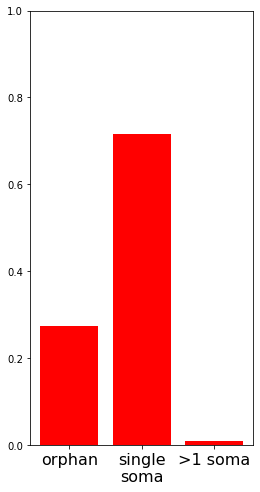

In [100]:
import matplotlib.pyplot as plt
vals = [0.27413325669930283, 0.7160017954569293, 0.00986494784376748]
f, ax = plt.subplots(figsize=(4,8))
ax.bar(range(0,3),vals, facecolor='r')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['orphan','single\nsoma', '>1 soma'], size=16)
ax.set_ylim([0,1])

In [67]:
col_df = client.materialize.query_table('allen_v1_column_types_slanted')

In [102]:
col_df.query('cell_type=="MC"').shape

(41, 7)

In [103]:
syn_dfs = []
for k, row in tqdm.tqdm_notebook(col_df.query('cell_type=="BC"').iterrows()):
    bc_df = client.materialize.synapse_query(pre_ids=row.pt_root_id, timestamp=now)
    syn_dfs.append(bc_df)

/var/folders/kx/xq42kw197c5_qw6kxgnr4nkr0000gq/T/ipykernel_47987/2872441583.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k, row in tqdm.tqdm_notebook(col_df.query('cell_type=="MC"').iterrows()):


0it [00:00, ?it/s]

In [104]:
bc_df = pd.concat(syn_dfs)

In [105]:
bc_dfm = pd.merge(bc_df, nuc_count, left_on='post_pt_root_id', right_index=True, how='left')

In [106]:
# this is calling anything which has exactly 1 nucleus detection the model called a neuron a single soma
single_soma_syn=bc_dfm.n_neuron_det.value_counts()[1.0]
single_soma_syn/len(bc_dfm)

0.8540332680672417

In [107]:
# orphans don't map to an object with a neuronal nucleus
orphan_syn = bc_dfm.n_neuron_det.isna().value_counts()[True]
orphan_syn/len(bc_dfm)

0.14028681801344128

In [108]:
# multi soma synapses are non-orphan, non-single soma
non_orphan = bc_dfm.n_neuron_det.isna().value_counts()[False]
multi_soma_syn = non_orphan - single_soma_syn

In [109]:
multi_soma_syn/len(bc_dfm)

0.005679913919316999

(0.0, 1.0)

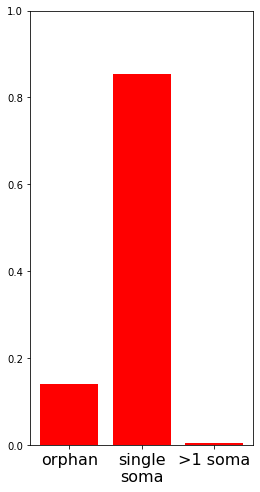

In [110]:
import matplotlib.pyplot as plt
vals = [0.14028681801344128, 0.8540332680672417, 0.005679913919316999]
f, ax = plt.subplots(figsize=(4,8))
ax.bar(range(0,3),vals, facecolor='r')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['orphan','single\nsoma', '>1 soma'], size=16)
ax.set_ylim([0,1])